<a href="https://colab.research.google.com/github/kranov582/mvp-1/blob/main/MVP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Análise de Dados e Boas Práticas

## Pedro Augusto Boller


## 1. Definição do Problema

O dataset utilizado neste projeto foi retirado de um grande banco de dados de uma indústria de metais. Ele contém diversas informações, como movimentações de estoque e transformações de materiais (da matéria-prima para material semi-acabado ou acabado, e de material semi-acabado para material acabado), movimentações financeiras (compra de produtos e matéria-prima, faturamento de produto acabado, entre outros) e movimentações de entrada e saída do estoque de qualidade, entre outras. As movimentações foram realizadas diariamente entre dezembro de 2021 e março de 2023.

Uma boa parte dos dados presentes neste conjunto, são os dados de ordens de produção. Esses dados serão o objetivo desta análise, por isso acredito ser necessario explicar brevemente como funciona uma ordem, para que seja mais facil compreender os dados nas próximas sessões.

Uma ordem de produção pode consumir matéria prima e gerar um produto semi-acabado (como uma bobina caster), pode consumir material semi-acabado e gerar outro material semi-acabado (passagem de uma máquina para outra), ou consumir um material semi-acabado e gerar um material acabado (produto pronto para o cliente).

Devido à diversidade de conteúdo, será necessário filtrar as linhas que serão usadas na análise, o que será explicado melhor na etapa de pré-processamento de dados. Os nomes reais dos materiais foram codificados pela empresa para manter a discrição dos dados.

Sendo um banco de dados real, há muitos dados irrelevantes para a análise, como colunas com dados constantes ou com a maioria das linhas contendo valores faltantes, além de diversas colunas com dados pouco úteis. O primeiro desafio será explorar essa grande quantidade de dados e filtrar o que não será útil para análise futura.

Após a filtragem inicial, será possível realizar diversas análises interessantes, como o rendimento metálico mensal, os produtos mais ou menos produzidos e a quantidade de movimentos feitos por código.

Em uma análise futura, o dataset pode ser utilizado para alimentar um modelo de aprendizado supervisionado de regressão, com o objetivo de prever a produção em um mês ou ano, com base em dados históricos.

Como se trata de um dataset muito grande, e que será bastante reduzido, não há necessidade de detalhar neste momento cada um dos atributos que ele contem. Isso será feito na etapa de pré-processamento, quando os dados estiverem limpos.

In [1]:
# Instalando o pandas profiling
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip (22.6 MB)
  Preparing metadata (setup.py) ... done


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
from matplotlib import cm
from matplotlib import dates
from pandas import set_option
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

<ipython-input-2-0dba39ab34c8>:12: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [3]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Para mostrar todas as linhas do pandas
pd.set_option('display.max_rows', None)

# Para mostrar todas as colunas do pandas
pd.set_option('display.max_columns', None)


## 2. Carga de Dados

Iremos usar o pacote Pandas (Python Data Analysis Library) para carregar de um arquivo .csv disponível online.

Com o dataset carregado, iremos explorá-lo um pouco.

In [4]:
# Carrega arquivo csv usando Pandas usando uma URL

# Informa a URL de importação do dataset
file_path = "https://media.githubusercontent.com/media/kranov582/mvp-1/main/analise_de_dados.csv"

# Lê o arquivo utilizando as colunas informadas
dataset = pd.read_csv(file_path, sep=';',encoding='ISO-8859-1')

In [5]:
dataset.head()

,Descrição motivo movimento,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Ano doc.material,Centro custo,Classificação contábil múltipla,Cliente,Cód.débito/crédito,Código de movimento,Código entrada,Consumo,Contador,Data de entrada,Data do documento,Diagrama de rede,Divisão ord.cliente,Documento do depósito,Elemento PEP,Empresa,Fornecedor,Hora do registro,Imobilizado,Item,Item gerado automaticamente,Item ord.cliente,Item ord.cliente.1,Linha original,Lote,Material Alterado,Classificação,Moeda,Montante em MI,Montante externo em MI,Motivo do movimento,Nº do depósito,nº do documento configurável,Nº do roteiro operações,Nº item reserva transferência,Nº reserva,Nota acomp.mercadoria,Operação,Ordem,Ordem do cliente,Ordem do cliente.1,Pedido,Qtd.em UM pedido,Qtd.em UPP,Quantidade,Segmento de estoque,Subnº,Texto cabeçalho documento,Tipo de avaliação,Tipo de operação,Txt.tipo movimento,UM pedido,Unid.medida básica,Unid.prç.pedido,Valor de venda,Valor PV com IVA
0,NaN,A001,NaN,101,NaN,5000023575,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,08:21:57,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.97,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
1,NaN,A001,NaN,101,NaN,5000023617,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,09:27:09,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.83,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
2,NaN,A001,NaN,101,NaN,5000023590,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,08:27:52,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.89,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
3,NaN,A001,NaN,101,NaN,5000023576,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,08:25:24,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.74,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
4,NaN,A001,NaN,101,NaN,5000023567,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,23/08/2022,23/08/2022,NaN,0,NaN,NaN,1000,1001168,17:50:31,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7157.45,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0


## 3. Análise de Dados Descritiva

### 3.1. Estatísticas Descritivas

A Análise será iniciada verificando as dimensões do dataset, algumas informações e as primeiras e ultimas linhas.

In [6]:
# Mostra as dimensões do dataset
print(dataset.shape)

(516490, 66)


Podemos verificar que se trata de um dataset muito grande, com mais de 500 mil linhas e 66 atributos.

In [7]:
# Mostra as informações do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516490 entries, 0 to 516489
Data columns (total 66 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Descrição motivo movimento       288 non-null     object 
 1   Centro                           516490 non-null  object 
 2   Depósito                         495490 non-null  object 
 3   Tipo de movimento                516490 non-null  object 
 4   Estoque especial                 186135 non-null  object 
 5   Doc.material                     516490 non-null  int64  
 6   Item doc.material                516490 non-null  int64  
 7   Data de lançamento               516490 non-null  object 
 8   Qtd.  UM registro                516490 non-null  float64
 9   UM registro                      516490 non-null  object 
 10  Ano doc.material                 516490 non-null  int64  
 11  Centro custo                     30138 non-null   object 
 12  Cl

Como é possivel notar nas informações acima, o dataset possui muitos valores missings, existindo até mesmo algumas colunas totalmente sem dados.

In [8]:
# Mostra as 10 primeiras linhas do dataset
dataset.head(10)

,Descrição motivo movimento,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Ano doc.material,Centro custo,Classificação contábil múltipla,Cliente,Cód.débito/crédito,Código de movimento,Código entrada,Consumo,Contador,Data de entrada,Data do documento,Diagrama de rede,Divisão ord.cliente,Documento do depósito,Elemento PEP,Empresa,Fornecedor,Hora do registro,Imobilizado,Item,Item gerado automaticamente,Item ord.cliente,Item ord.cliente.1,Linha original,Lote,Material Alterado,Classificação,Moeda,Montante em MI,Montante externo em MI,Motivo do movimento,Nº do depósito,nº do documento configurável,Nº do roteiro operações,Nº item reserva transferência,Nº reserva,Nota acomp.mercadoria,Operação,Ordem,Ordem do cliente,Ordem do cliente.1,Pedido,Qtd.em UM pedido,Qtd.em UPP,Quantidade,Segmento de estoque,Subnº,Texto cabeçalho documento,Tipo de avaliação,Tipo de operação,Txt.tipo movimento,UM pedido,Unid.medida básica,Unid.prç.pedido,Valor de venda,Valor PV com IVA
0,NaN,A001,NaN,101,NaN,5000023575,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,08:21:57,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.97,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
1,NaN,A001,NaN,101,NaN,5000023617,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,09:27:09,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.83,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
2,NaN,A001,NaN,101,NaN,5000023590,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,08:27:52,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.89,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
3,NaN,A001,NaN,101,NaN,5000023576,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,08:25:24,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.74,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
4,NaN,A001,NaN,101,NaN,5000023567,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,23/08/2022,23/08/2022,NaN,0,NaN,NaN,1000,1001168,17:50:31,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7157.45,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
5,NaN,A001,NaN,101,NaN,5000023568,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,23/08/2022,23/08/2022,NaN,0,NaN,NaN,1000,1001168,17:53:06,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.99,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
6,NaN,A001,NaN,101,NaN,5000023570,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,23/08/2022,23/08/2022,NaN,0,NaN,NaN,1000,1001168,17:58:56,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7149.86,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
7,NaN,A001,NaN,101,NaN,5000023569,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,23/08/2022,23/08/2022,NaN,0,NaN,NaN,1000,1001168,17:55:02,NaN,10,NaN,0,0,0,NaN,0,##,BRL,7156.99,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
8,NaN,A001,NaN,101,NaN,5000023591,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,08:30:15,NaN,10,NaN,0,0,0,NaN,0,##,BRL,6438.89,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
9,NaN,A001,NaN,101,NaN,5000023595,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,NaN,S,B,NaN,V,0,24/08/2022,24/08/2022,NaN,0,NaN,NaN,1000,1001168,08:33:14,NaN,10,NaN,0,0,0,NaN,0,##,BRL,6437.93,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,Na

Logo nas primeiras linhas, podemos verificar o que foi apontado pela análise anterior, existem muitos valores com dados faltantes, e muitas colunas com dados unicos (constantes). Isso será comprovado pela análise do pandas profilling na próxima sessão.

In [9]:
# Mostra as 10 últimas linhas do dataset
dataset.tail(10)

,Descrição motivo movimento,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Ano doc.material,Centro custo,Classificação contábil múltipla,Cliente,Cód.débito/crédito,Código de movimento,Código entrada,Consumo,Contador,Data de entrada,Data do documento,Diagrama de rede,Divisão ord.cliente,Documento do depósito,Elemento PEP,Empresa,Fornecedor,Hora do registro,Imobilizado,Item,Item gerado automaticamente,Item ord.cliente,Item ord.cliente.1,Linha original,Lote,Material Alterado,Classificação,Moeda,Montante em MI,Montante externo em MI,Motivo do movimento,Nº do depósito,nº do documento configurável,Nº do roteiro operações,Nº item reserva transferência,Nº reserva,Nota acomp.mercadoria,Operação,Ordem,Ordem do cliente,Ordem do cliente.1,Pedido,Qtd.em UM pedido,Qtd.em UPP,Quantidade,Segmento de estoque,Subnº,Texto cabeçalho documento,Tipo de avaliação,Tipo de operação,Txt.tipo movimento,UM pedido,Unid.medida básica,Unid.prç.pedido,Valor de venda,Valor PV com IVA
516480,NaN,A001,NaN,101,NaN,5000006822,1,11/04/2022,1.0,HRS,2022,A005ATR112,NaN,NaN,S,B,NaN,V,0,11/04/2022,11/04/2022,NaN,0,NaN,NaN,1000,1014497,09:34:54,NaN,10,NaN,0,0,0,NaN,2183,Materia prima,BRL,654.76,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,1.0,1.0,1.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516481,NaN,A001,NaN,101,NaN,5000006823,1,11/04/2022,1.0,HRS,2022,A005ATR112,NaN,NaN,S,B,NaN,V,0,11/04/2022,11/04/2022,NaN,0,NaN,NaN,1000,1014497,09:38:16,NaN,20,NaN,0,0,0,NaN,2183,Materia prima,BRL,654.76,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,1.0,1.0,1.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516482,NaN,A001,NaN,101,NaN,5000006824,1,11/04/2022,1.0,HRS,2022,A005ATR112,NaN,NaN,S,B,NaN,V,0,11/04/2022,11/04/2022,NaN,0,NaN,NaN,1000,1014497,09:40:29,NaN,30,NaN,0,0,0,NaN,2183,Materia prima,BRL,654.76,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,1.0,1.0,1.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516483,NaN,A001,NaN,101,NaN,5000006825,1,11/04/2022,1.0,HRS,2022,A005ATR112,NaN,NaN,S,B,NaN,V,0,11/04/2022,11/04/2022,NaN,0,NaN,NaN,1000,1014497,09:42:01,NaN,40,NaN,0,0,0,NaN,2183,Materia prima,BRL,654.76,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,1.0,1.0,1.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516484,NaN,A001,NaN,101,NaN,5000006736,1,08/04/2022,1.0,HRS,2022,A001ALM112,NaN,NaN,S,B,NaN,V,0,08/04/2022,08/04/2022,NaN,0,NaN,NaN,1000,1000366,11:07:53,NaN,10,NaN,0,0,0,NaN,2183,Materia prima,BRL,6625.00,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,1.0,1.0,1.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516485,NaN,A001,NaN,101,NaN,5000006736,2,08/04/2022,1.0,HRS,2022,A001ALM112,NaN,NaN,S,B,NaN,V,0,08/04/2022,08/04/2022,NaN,0,NaN,NaN,1000,1000366,11:07:53,NaN,20,NaN,0,0,0,NaN,2183,Materia prima,BRL,6625.00,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,1.0,1.0,1.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516486,NaN,A001,NaN,101,NaN,5000006736,3,08/04/2022,1.0,HRS,2022,A001ALM112,NaN,NaN,S,B,NaN,V,0,08/04/2022,08/04/2022,NaN,0,NaN,NaN,1000,1000366,11:07:53,NaN,30,NaN,0,0,0,NaN,2183,Materia prima,BRL,6625.00,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,1.0,1.0,1.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516487,NaN,A001,NaN,101,NaN,5000006736,4,08/04/2022,1.0,HRS,2022,A001ALM112,NaN,NaN,S,B,NaN,V,0,08/04/2022,08/04/2022,NaN,0,NaN,NaN,1000,1000366,11:07:53,NaN,40,NaN,0,0,0,NaN,2183,Materia prima,BRL,6625.00,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,1.0,1.0,1.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516488,NaN,A001,NaN,101,NaN,5000006743,1,08/04/2022,4.0,HRS,2022,A005ATR112,NaN,NaN,S,B,NaN,V,0,08/04/2022,08/04/2022,NaN,0,NaN,NaN,1000,1014497,10:52:18,NaN,10,NaN,0,0,0,NaN,2183,Materia prima,BRL,2619.04,0.0,0,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,4.500003e+09,4.0,4.0,4.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,HRS,HRS,HRS,0,0
516489,NaN,A001,NaN,101,NaN,5000006052,1,31/03/2022,1.0,H

In [10]:
# Verifica o tipo de dataset de cada atributo
dataset.dtypes

Descrição motivo movimento          object
Centro                              object
Depósito                            object
Tipo de movimento                   object
Estoque especial                    object
Doc.material                         int64
Item doc.material                    int64
Data de lançamento                  object
Qtd.  UM registro                  float64
UM registro                         object
Ano doc.material                     int64
Centro custo                        object
Classificação contábil múltipla     object
Cliente                            float64
Cód.débito/crédito                  object
Código de movimento                 object
Código entrada                      object
Consumo                             object
Contador                             int64
Data de entrada                     object
Data do documento                   object
Diagrama de rede                    object
Divisão ord.cliente                  int64
Documento d

Será necessario converter os dados de grande parte das colunas, pois não possuem o tipo de dado correto.

### 3.2. Pandas Profilling
Como foi verificado diversos problemas nos dados, e como se tratam de muitas colunas e linhas, o pandas profilling torna análise muito mais facil, pois nele é destacado os principais avisos das caracteristicas do dataset.

In [11]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset.describe()

,Doc.material,Item doc.material,Qtd. UM registro,Ano doc.material,Cliente,Contador,Divisão ord.cliente,Documento do depósito,Empresa,Item,Item ord.cliente,Item ord.cliente.1,Linha original,Material Alterado,Montante em MI,Montante externo em MI,Motivo do movimento,Nº do depósito,nº do documento configurável,Nº do roteiro operações,Nº item reserva transferência,Nº reserva,Nota acomp.mercadoria,Operação,Ordem do cliente.1,Pedido,Quantidade,Segmento de estoque,Tipo de avaliação,Valor de venda,Valor PV com IVA
count,5.164900e+05,516490.000000,5.164900e+05,516490.000000,3.041100e+04,516490.000000,516490.0,0.0,516490.0,516490.000000,516490.000000,516490.00000,516490.000000,516490.000000,5.164900e+05,5.164900e+05,516490.000000,0.0,0.0,5.164900e+05,516490.000000,5.164900e+05,0.0,14.0,1.850320e+05,5.123500e+04,5.164900e+05,0.0,0.0,516490.0,516490.0
mean,4.905997e+09,13.957871,4.971316e+01,2022.133205,1.007461e+06,0.886118,0.0,NaN,1000.0,13.731263,10.208873,11.90988,0.001417,3046.761054,3.388515e+02,1.483765e+02,0.014465,NaN,NaN,3.543900e+05,1.139794,1.838086e+05,NaN,20.0,7.266979e+05,6.011294e+09,5.202804e+01,NaN,NaN,0.0,0.0
std,2.320453e+07,90.512070,2.314441e+04,0.384099,5.009154e+03,1.456362,0.0,NaN,0.0,70.049757,25.534336,27.00965,0.121599,1113.815581,5.797301e+04,2.676158e+04,1.114841,NaN,NaN,1.866548e+07,6.431602,3.915162e+05,NaN,0.0,6.511055e+06,1.278761e+09,2.314621e+04,NaN,NaN,0.0,0.0
min,4.900000e+09,1.000000,-1.100000e+07,2021.000000,1.000045e+06,0.000000,0.0,NaN,1000.0,0.000000,0.000000,0.00000,0.000000,0.000000,-1.325008e+07,-1.033922e+06,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,NaN,20.0,3.000000e+00,4.500000e+09,-1.100000e+07,NaN,NaN,0.0,0.0
25%,4.900123e+09,1.000000,-4.040000e+02,2022.000000,1.003116e+06,0.000000,0.0,NaN,1000.0,0.000000,0.000000,0.00000,0.000000,2256.000000,-1.593900e+02,0.000000e+00,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,NaN,20.0,5.683000e+03,4.500009e+09,-4.040000e+02,NaN,NaN,0.0,0.0
50%,4.900277e+09,2.000000,-1.220000e+00,2022.000000,1.007400e+06,1.000000,0.0,NaN,1000.0,0.000000,0.000000,0.00000,0.000000,2911.000000,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,0.000000e+00,0.000000,0.000000e+00,NaN,20.0,1.264100e+04,7.000001e+09,-1.220000e+00,NaN,NaN,0.0,0.0
75%,4.900449e+09,2.000000,3.350000e+02,2022.000000,1.009676e+06,1.000000,0.0,NaN,1000.0,0.000000,10.000000,10.00000,0.000000,3404.000000,1.063500e+01,0.000000e+00,0.000000,NaN,NaN,9.381000e+03,1.000000,9.648000e+03,NaN,20.0,1.714100e+04,7.000004e+09,3.350000e+02,NaN,NaN,0.0,0.0
max,5.000047e+09,1695.000000,1.100000e+07,2023.000000,1.019663e+06,18.000000,0.0,NaN,1000.0,2600.000000,500.000000,500.00000,46.000000,9817.000000,1.352276e+07,1.630237e+07,203.000000,NaN,NaN,1.000076e+09,346.000000,1.574972e+06,NaN,20.0,6.000238e+07,8.500015e+09,1.100000e+07,NaN,NaN,0.0,0.0


Como os dados estão muito bagunçados, não é possivel tirar nenhuma análise útil com o comando describe nesse momento.

In [12]:
# Análise do pandas profiling
'''
profile = ProfileReport(dataset, title='Pandas Profiling Report', 
                        html={'style':{'full_width':False}})
profile.to_notebook_iframe()
'''

"\nprofile = ProfileReport(dataset, title='Pandas Profiling Report', \n                        html={'style':{'full_width':False}})\nprofile.to_notebook_iframe()\n"

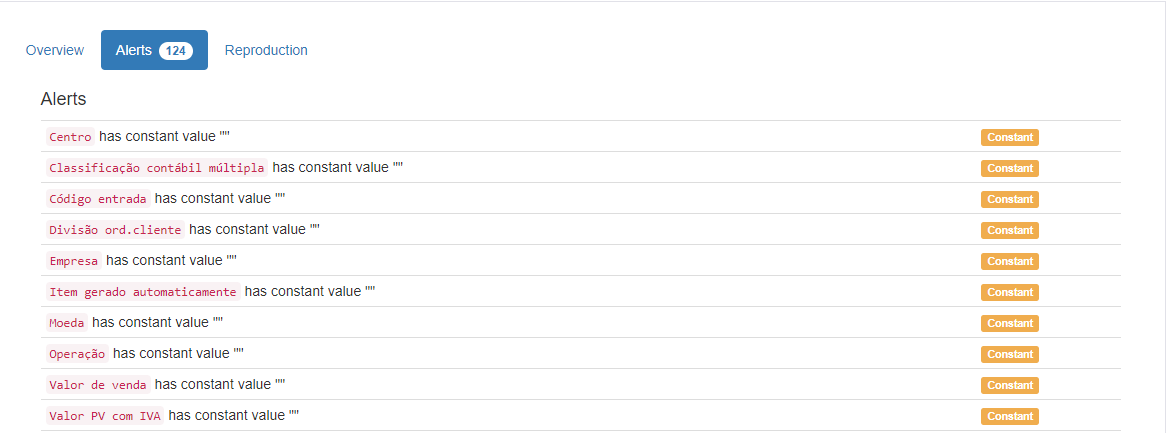

Existem várias colunas com valores constantes

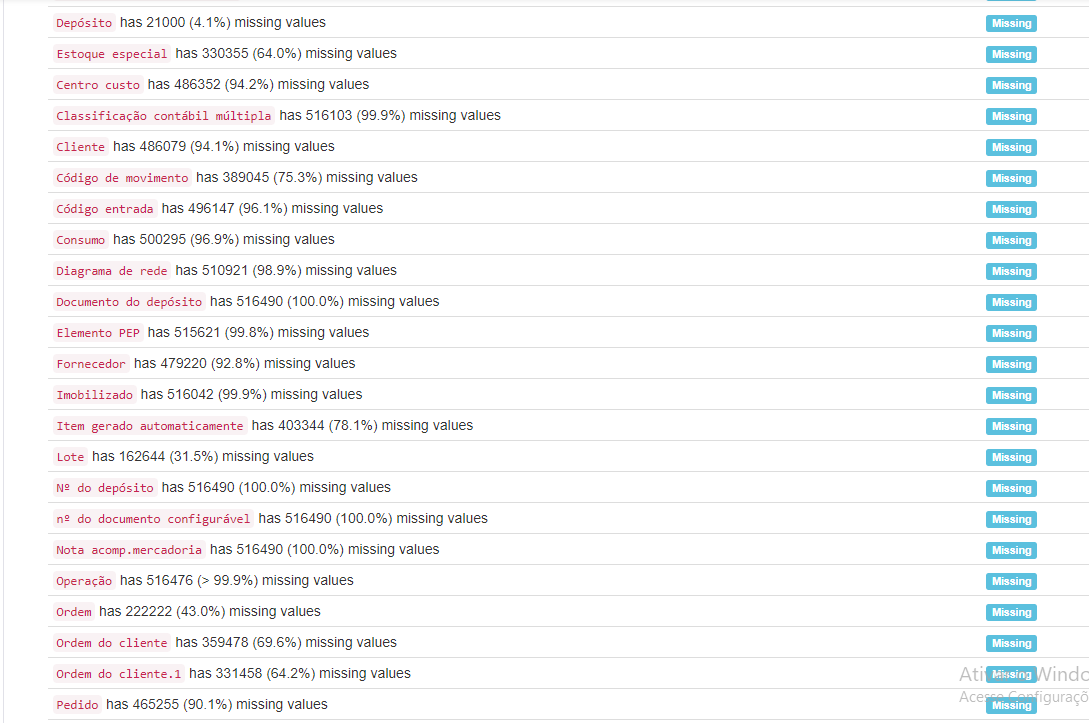

É possivel analizar que existem muitos atributos com valores faltantes, inclusive algumas colunas estão completamente sem dados.

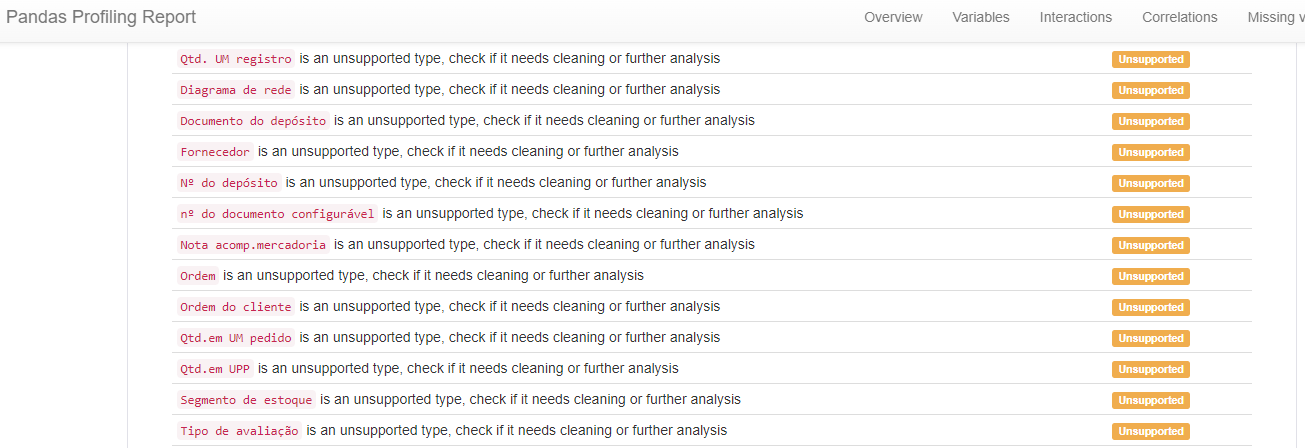

Existem tambem muitos colunas com dados indefinidos, que precisam ser convertidos para o formato correto para evitar erros.

## 4. Pré-Processamento de dados

Nesta etapa, serão realizados diversas operações de preparação de dados, como por exemplo, tratamento de valores missings (faltantes), formatação dos tipos de dados e a eliminação de colunas constantes.

Antes de tudo, será necessario definir qual será o escopo da análise, pois como foi descrito anteriormente, este conjunto de dados possui dados monetarios, dados em unidades de peso, unidades de comprimento, etc. 

Para reduzir esse escopo, será necessarios filtrar os códigos de movimentação, pois são eles que definem basicamente todo o resto das linhas dos atributos, visto que elas definem o que foi trasnferido. Os movimentos que serão usados na análise são: 101, 102, 261 e 262.

Estes códigos são os mais utilizados dentro das ordens de produção do cliente, e são fundamentais para qualquer análise que tem como objetivo saber algo sobre a produção.

Abaixo está a legenda de cada um dos códigos:

**101**: Entrada de mercadorias (da ordem) para o estoque\
**102**: Estorno do movimento 101\
**261**: Saida de mercadorias (do estoque) para a ordem\
**262**: Estorno do movimento 261

Olhando do aspecto de transformação do produto pelo refencial da ordem do cliente, o movimento 261 é considerado a entrada do material para dentro de uma ordem de produção para ser consumido, com o objetivo de gerar outro material, e o movimento 101 é uma saida de material pronto.

Porem, no banco de dados, estes valores estão sendo vistos do referencial do estoque. Ou seja, os valores de entrada da ordem estão negativos (pois estão saindo do estoque) e os valores de saida da ordem estão positivos (pois estão entrando no estoque).


Abaixo está o codigo que filtra os tipos de movimentos que serão usados neste trabalho:

In [13]:
# Cria uma nova instancia do dataset, para realizar o processamento
dataset_processado = dataset

dataset_processado = dataset_processado.astype({'Tipo de movimento': 'str'})

# Faz uma lista com os valores que serão filtrados
allowed_values = ['101', '102', '261', '262']

# Cria a mascara
mask = dataset_processado['Tipo de movimento'].isin(allowed_values)

# Aplica a mascara
dataset_processado = dataset_processado[mask]

# Verifica se foi aplicado
dataset_processado.groupby('Tipo de movimento').count()

,Descrição motivo movimento,Centro,Depósito,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Ano doc.material,Centro custo,Classificação contábil múltipla,Cliente,Cód.débito/crédito,Código de movimento,Código entrada,Consumo,Contador,Data de entrada,Data do documento,Diagrama de rede,Divisão ord.cliente,Documento do depósito,Elemento PEP,Empresa,Fornecedor,Hora do registro,Imobilizado,Item,Item gerado automaticamente,Item ord.cliente,Item ord.cliente.1,Linha original,Lote,Material Alterado,Classificação,Moeda,Montante em MI,Montante externo em MI,Motivo do movimento,Nº do depósito,nº do documento configurável,Nº do roteiro operações,Nº item reserva transferência,Nº reserva,Nota acomp.mercadoria,Operação,Ordem,Ordem do cliente,Ordem do cliente.1,Pedido,Qtd.em UM pedido,Qtd.em UPP,Quantidade,Segmento de estoque,Subnº,Texto cabeçalho documento,Tipo de avaliação,Tipo de operação,Txt.tipo movimento,UM pedido,Unid.medida básica,Unid.prç.pedido,Valor de venda,Valor PV com IVA
Tipo de movimento,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101,0,73570,60430,27162,73570,73570,73570,73570,73570,73570,7687,354,0,73570,73570,488,13586,73570,73570,73570,3674,73570,0,641,73570,21391,73570,412,73570,0,73570,73570,73570,52567,73570,73570,73570,73570,73570,73570,0,0,73570,73570,73570,0,0,54982,354,26696,21391,73570,73570,73570,0,412,11,0,73570,73570,73570,71973,21391,73570,73570
102,0,4845,3369,974,4845,4845,4845,4845,4845,4845,818,33,0,4845,4845,230,1524,4845,4845,4845,380,4845,0,61,4845,2541,4845,36,4845,0,4845,4845,4845,2493,4845,4845,4845,4845,4845,4845,0,0,4845,4845,4845,0,0,2678,33,932,2541,4845,4845,4845,0,36,1,0,4845,4845,4845,4788,2541,4845,4845
261,0,90183,90183,30,90183,90183,90183,90183,90183,90183,0,0,1,90183,0,0,0,90183,90183,90183,0,90183,0,0,90183,0,90183,0,90183,0,90183,90183,90183,50626,90183,90183,90183,90183,90183,90183,0,0,90183,90183,90183,0,0,90183,0,30,0,90183,90183,90183,0,0,0,0,90183,90183,0,90183,0,90183,90183
262,0,4330,4330,1,4330,4330,4330,4330,4330,4330,0,0,0,4330,0,0,0,4330,4330,4330,0,4330,0,0,4330,0,4330,0,4330,0,4330,4330,4330,2208,4330,4330,4330,4330,4330,4330,0,0,4330,4330,4330,0,0,4330,0,1,0,4330,4330,4330,0,0,0,0,4330,4330,0,4330,0,4330,4330


### 4.1. Tratamento de Missings, limpeza dos dados e eliminação de atributos constantes

Como foi visto na sessão de análise, existem muitos problemas que precisam ser tratados nesse dataset.

Primeiramente, serão excluidos do dataset as colunas com valores constantes, pois elas não agregam em nada na análise.

In [14]:
dataset_processado = dataset_processado.drop(
    columns=['Centro', 'Classificação contábil múltipla','Código entrada', 
             'Divisão ord.cliente', 'Empresa', 'Item gerado automaticamente', 
              'Moeda', 'Operação'])

Antes de seguir para a etapa de eliminação das colunas com missings, será necessario preecher os dados faltantes de algumas colunas que possuem dados muito importantes, e não podem ser removidas. Esse é o caso das colunas "Depósito", "Ordem", e "Lote".

Como as colunas possuem muitos dados de diversas na naturezas, algumas movimentações não possuem dados nesses atributos.

Como esses dados não estão faltantes por algum erro ou por falta de preenchimento, não faz sentido remover as linhas em que eles não aparecem. A melhor solução nesse caso é substituir os valores por uma string.

In [15]:
dataset_processado['Depósito'].fillna(value='Sem depósito', inplace=True)
dataset_processado['Ordem'].fillna(value='Sem ordem', inplace=True)
dataset_processado['Lote'].fillna(value='Sem lote', inplace=True)
dataset_processado.head(10)

,Descrição motivo movimento,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Ano doc.material,Centro custo,Cliente,Cód.débito/crédito,Código de movimento,Consumo,Contador,Data de entrada,Data do documento,Diagrama de rede,Documento do depósito,Elemento PEP,Fornecedor,Hora do registro,Imobilizado,Item,Item ord.cliente,Item ord.cliente.1,Linha original,Lote,Material Alterado,Classificação,Montante em MI,Montante externo em MI,Motivo do movimento,Nº do depósito,nº do documento configurável,Nº do roteiro operações,Nº item reserva transferência,Nº reserva,Nota acomp.mercadoria,Ordem,Ordem do cliente,Ordem do cliente.1,Pedido,Qtd.em UM pedido,Qtd.em UPP,Quantidade,Segmento de estoque,Subnº,Texto cabeçalho documento,Tipo de avaliação,Tipo de operação,Txt.tipo movimento,UM pedido,Unid.medida básica,Unid.prç.pedido,Valor de venda,Valor PV com IVA
0,NaN,Sem depósito,101,NaN,5000023575,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,24/08/2022,24/08/2022,NaN,NaN,NaN,1001168,08:21:57,NaN,10,0,0,0,Sem lote,0,##,7156.97,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
1,NaN,Sem depósito,101,NaN,5000023617,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,24/08/2022,24/08/2022,NaN,NaN,NaN,1001168,09:27:09,NaN,10,0,0,0,Sem lote,0,##,7156.83,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
2,NaN,Sem depósito,101,NaN,5000023590,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,24/08/2022,24/08/2022,NaN,NaN,NaN,1001168,08:27:52,NaN,10,0,0,0,Sem lote,0,##,7156.89,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
3,NaN,Sem depósito,101,NaN,5000023576,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,24/08/2022,24/08/2022,NaN,NaN,NaN,1001168,08:25:24,NaN,10,0,0,0,Sem lote,0,##,7156.74,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
4,NaN,Sem depósito,101,NaN,5000023567,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,23/08/2022,23/08/2022,NaN,NaN,NaN,1001168,17:50:31,NaN,10,0,0,0,Sem lote,0,##,7157.45,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
5,NaN,Sem depósito,101,NaN,5000023568,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,23/08/2022,23/08/2022,NaN,NaN,NaN,1001168,17:53:06,NaN,10,0,0,0,Sem lote,0,##,7156.99,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
6,NaN,Sem depósito,101,NaN,5000023570,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,23/08/2022,23/08/2022,NaN,NaN,NaN,1001168,17:58:56,NaN,10,0,0,0,Sem lote,0,##,7149.86,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
7,NaN,Sem depósito,101,NaN,5000023569,1,23/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,23/08/2022,23/08/2022,NaN,NaN,NaN,1001168,17:55:02,NaN,10,0,0,0,Sem lote,0,##,7156.99,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
8,NaN,Sem depósito,101,NaN,5000023591,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,24/08/2022,24/08/2022,NaN,NaN,NaN,1001168,08:30:15,NaN,10,0,0,0,Sem lote,0,##,6438.89,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0
9,NaN,Sem depósito,101,NaN,5000023595,1,24/08/2022,1.0,UA,2022,A001ALM301,NaN,S,B,V,0,24/08/2022,24/08/2022,NaN,NaN,NaN,1001168,08:33:14,NaN,10,0,0,0,Sem lote,0,##,6437.93,0.0,0,NaN,NaN,0,0,0,NaN,Sem ordem,NaN,NaN,8.500006e+09,1,1,0.0,NaN,NaN,NaN,NaN,WE,EM p/ClassCont.,UA,NaN,UA,0,0


Agora serão eliminadas as colunas que possuem mais de 90% dos dados faltantes

In [16]:
# Código para remover as colunas que possuem dados com mais de 90% do total como missings.

# Define o limiar para 90% de valores não-nulos
thresh = len(dataset_processado) * 0.90  

# Remove as colunas que não atingem o limiar
dataset_processado.dropna(thresh=thresh, axis=1, inplace = True)  

dataset_processado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172928 entries, 0 to 516489
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Depósito                       172928 non-null  object 
 1   Tipo de movimento              172928 non-null  object 
 2   Doc.material                   172928 non-null  int64  
 3   Item doc.material              172928 non-null  int64  
 4   Data de lançamento             172928 non-null  object 
 5   Qtd.  UM registro              172928 non-null  float64
 6   UM registro                    172928 non-null  object 
 7   Ano doc.material               172928 non-null  int64  
 8   Cód.débito/crédito             172928 non-null  object 
 9   Contador                       172928 non-null  int64  
 10  Data de entrada                172928 non-null  object 
 11  Data do documento              172928 non-null  object 
 12  Hora do registro              

O dataset agora está quase totalmente livre de valores faltantes, com excessão da coluna "Unid.medida básica".

A coluna "Unid.medida básica" contem valores de unidades de medidas. Porem, analisando o dataframe, podemos notar que existe tambem a coluna "UM registro", que aparentemente tambem contem unidades de medida. Podemos fazer uma verificação se essas duas colunas são iguais, e se forem, podemos eliminar a que contem valores faltantes.

Para fazer essa verificação, podemos usar a função abaixo:

In [17]:
def verificar_colunas(coluna1, coluna2, dataset):
    col1 = dataset[f"{coluna1}"].values
    col2 = dataset[f"{coluna2}"].values


    # inicialize a variável de contagem
    count = 0

    # percorra as duas listas simultaneamente e compare os valores
    for item1, item2 in zip(col1, col2):
        if item1 == item2:
            count += 1
        
    # calcule o percentual de similaridade
    percentual_similaridade = (count / len(col1)) * 100

    # imprima o resultado
    print(f"Os valores das colunas são {percentual_similaridade:.2f}% iguais.")

In [18]:
verificar_colunas('Unid.medida básica', 'UM registro', dataset_processado)

Os valores das colunas são 98.88% iguais.


A suspeita foi comprovada, como mostra o resultado impresso pela função. Podemos então eliminar a coluna com dados faltantes sem maiores preucupações.

Podemos aproveitar a função para análisar outras colunas que tambem possuem a suspeita de terem valores iguais, como é o caso das colunas com valores de data.

In [19]:
verificar_colunas('Data do documento', 'Data de entrada', dataset_processado)
verificar_colunas('Data do documento', 'Data de lançamento', dataset_processado)
verificar_colunas('Data de entrada', 'Data de lançamento', dataset_processado)

Os valores das colunas são 95.76% iguais.
Os valores das colunas são 98.31% iguais.
Os valores das colunas são 97.22% iguais.


As 3 colunas possuem mais de 95% de similaridade. Podemos escolher apenas uma delas para representar a data, e as outras duas podem ser descartadas. A coluna "Data de lançamento" será escolhida, e as outras duas serão removidas

Existem tambem duas colunas com valores de quantidade:

In [20]:
verificar_colunas('Quantidade', 'Qtd.  UM registro', dataset_processado)

Os valores das colunas são 99.00% iguais.


As duas colunas são praticamente iguais. Será escolhido a coluna "Quantidade" para ser mantida.

In [21]:
dataset_processado = dataset_processado.drop(columns = ['Data de entrada', 'Data do documento', 'Unid.medida básica', 'Qtd.  UM registro'])

Como foi visto anteriormente, varias colunas estão com a estrutura de dados definida de modo equivocada. No proximo passo, vamos converter os dados para um tipo mais adequado para cada coluna.

In [22]:
# Alterar a data para o formato datetime
dataset_processado['Data de lançamento'] = pd.to_datetime(dataset_processado['Data de lançamento'], format='%d/%m/%Y')
dataset_processado['Hora do registro'] = pd.to_datetime(dataset_processado['Hora do registro'], format='%H:%M:%S')

# Alterar os valores de quantidade para numericos
dataset_processado['Quantidade'] = pd.to_numeric(dataset_processado['Quantidade'])
dataset_processado['Montante em MI'] = pd.to_numeric(dataset_processado['Montante em MI'])
dataset_processado['Montante externo em MI'] = pd.to_numeric(dataset_processado['Montante externo em MI'])

# Alterar o tipo de dados das colunas restantes para str
dataset_processado = dataset_processado.astype(
    {'Depósito': 'str', 'Tipo de movimento': 'str', 'Cód.débito/crédito': 'str',
     'UM registro': 'str', 'Classificação': 'str','Qtd.em UM pedido': 'str', 
     'Qtd.em UPP': 'str','Tipo de operação': 'str', 'Txt.tipo movimento': 'str',
     'Doc.material': 'str','Item doc.material': 'str', 'Ano doc.material': 'str',
     'Item': 'str', 'Item ord.cliente': 'str', 'Item ord.cliente.1': 'str',
     'Linha original' : 'str', 'Material Alterado': 'str', 
     'Motivo do movimento': 'str',})

In [23]:
# imprimir informações atualizadas do dataset
dataset_processado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172928 entries, 0 to 516489
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Depósito                       172928 non-null  object        
 1   Tipo de movimento              172928 non-null  object        
 2   Doc.material                   172928 non-null  object        
 3   Item doc.material              172928 non-null  object        
 4   Data de lançamento             172928 non-null  datetime64[ns]
 5   UM registro                    172928 non-null  object        
 6   Ano doc.material               172928 non-null  object        
 7   Cód.débito/crédito             172928 non-null  object        
 8   Contador                       172928 non-null  int64         
 9   Hora do registro               172928 non-null  datetime64[ns]
 10  Item                           172928 non-null  object        
 11  

Agora que o dataset está processado, podemos seguir para a análise de dados. Porem, antes de fazer isso, será necessario fazer uma engenharia de atributos, pois o dataset ainda está grande, e com varias colunas que não serão uteis para a análise. Os atributos serão escolhidos de acordo com os meus conhecimentos sobre os dados.

Vamos analisar cada um dos atributos, e identificar o que significam. Algumas não são utilizadas e outras não consegui compreender o significado:

Depósito: Se trata do deposito para onde ocorreu a movimentação;

Tipo de movimento: Se trata do código do movimento que foi realizado;

Doc. material: Número que rastreia um determinado movimento de um material;

Item doc.material: Acompanha o Doc. material, e é usado quando algum movimento possui mais de um material;

Data de lançamento: Quando foi feito o movimento;

UM registro: A unidade de medida do material do movimento;

Ano doc.material: Ano que foi feito a transferencia;

Cód.débito/crédito: Indica se o movimento causou um débito ou crédito, do referencial do estoque;

Contador: Significado da coluna não conhecido;

Hora do registro: Hora em que ocorreu a movimentação;

Item: Significado da coluna não conhecido;

Item ord.cliente: Quando o movimento ocorre em uma ordem de cliente, esse campo mostra o numero do item da ordem;

Item ord.cliente1.: Significado da coluna não conhecido;

Linha original: Significado da coluna não conhecido;

Lote: Numero do lote do material;

Material Alterado: Código único de cada material. Não corresponde aos valores reais, pois o código foi alterado para preservar a confidencialidade;

Classificação: Classificação feita artificialmente para facilitar a organização dos itens;

Montante em MI: Valor em reais dos materiais movimentados;

Montante externo em MI: Significado da coluna não conhecido;

Motivo do movimento: Não utilizado;

Nº do roteiro operações: Não utilizado;

Nº item reserva transferência: Não utilizado;

Nº reserva: Não utilizado;

Ordem: Número da ordem do cliente

Qtd.em UM pedido: Não utilizado;

Qtd.em UPP: Não utilizado;

Quantidade: Quantidade do material que foi transferida, na unidade presente na coluna "UM registro";

Tipo de operação: Não utilizado;

Txt.tipo movimento: Descrição do código do movimento da coluna "Tipo de movimento";

Valor de venda: Não utilizado;

Valor PV com IVA: Não utilizado

In [24]:
dataset_processado.head(10)

,Depósito,Tipo de movimento,Doc.material,Item doc.material,Data de lançamento,UM registro,Ano doc.material,Cód.débito/crédito,Contador,Hora do registro,Item,Item ord.cliente,Item ord.cliente.1,Linha original,Lote,Material Alterado,Classificação,Montante em MI,Montante externo em MI,Motivo do movimento,Nº do roteiro operações,Nº item reserva transferência,Nº reserva,Ordem,Qtd.em UM pedido,Qtd.em UPP,Quantidade,Tipo de operação,Txt.tipo movimento,Valor de venda,Valor PV com IVA
0,Sem depósito,101,5000023575,1,2022-08-24,UA,2022,S,0,1900-01-01 08:21:57,10,0,0,0,Sem lote,0,##,7156.97,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
1,Sem depósito,101,5000023617,1,2022-08-24,UA,2022,S,0,1900-01-01 09:27:09,10,0,0,0,Sem lote,0,##,7156.83,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
2,Sem depósito,101,5000023590,1,2022-08-24,UA,2022,S,0,1900-01-01 08:27:52,10,0,0,0,Sem lote,0,##,7156.89,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
3,Sem depósito,101,5000023576,1,2022-08-24,UA,2022,S,0,1900-01-01 08:25:24,10,0,0,0,Sem lote,0,##,7156.74,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
4,Sem depósito,101,5000023567,1,2022-08-23,UA,2022,S,0,1900-01-01 17:50:31,10,0,0,0,Sem lote,0,##,7157.45,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
5,Sem depósito,101,5000023568,1,2022-08-23,UA,2022,S,0,1900-01-01 17:53:06,10,0,0,0,Sem lote,0,##,7156.99,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
6,Sem depósito,101,5000023570,1,2022-08-23,UA,2022,S,0,1900-01-01 17:58:56,10,0,0,0,Sem lote,0,##,7149.86,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
7,Sem depósito,101,5000023569,1,2022-08-23,UA,2022,S,0,1900-01-01 17:55:02,10,0,0,0,Sem lote,0,##,7156.99,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
8,Sem depósito,101,5000023591,1,2022-08-24,UA,2022,S,0,1900-01-01 08:30:15,10,0,0,0,Sem lote,0,##,6438.89,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0
9,Sem depósito,101,5000023595,1,2022-08-24,UA,2022,S,0,1900-01-01 08:33:14,10,0,0,0,Sem lote,0,##,6437.93,0.0,0,0,0,0,Sem ordem,1,1,0.0,WE,EM p/ClassCont.,0,0


As colunas usadas serão as seguintes:

Ordem;\
Doc.Material;\
Item doc.Material;\
Lote;\
Depósito;\
Tipo de movimentação;\
Data de lançamento;\
Material alterado;\
Classificação;\
Quantidade;\
UM registro

In [25]:
dataset_finalizado = dataset_processado[['Ordem','Doc.material','Item doc.material','Lote', 'Depósito', 'Tipo de movimento', 'Data de lançamento', 'Material Alterado', 'Classificação',  'UM registro','Quantidade']]

In [26]:
dataset_finalizado.head(10)

,Ordem,Doc.material,Item doc.material,Lote,Depósito,Tipo de movimento,Data de lançamento,Material Alterado,Classificação,UM registro,Quantidade
0,Sem ordem,5000023575,1,Sem lote,Sem depósito,101,2022-08-24,0,##,UA,0.0
1,Sem ordem,5000023617,1,Sem lote,Sem depósito,101,2022-08-24,0,##,UA,0.0
2,Sem ordem,5000023590,1,Sem lote,Sem depósito,101,2022-08-24,0,##,UA,0.0
3,Sem ordem,5000023576,1,Sem lote,Sem depósito,101,2022-08-24,0,##,UA,0.0
4,Sem ordem,5000023567,1,Sem lote,Sem depósito,101,2022-08-23,0,##,UA,0.0
5,Sem ordem,5000023568,1,Sem lote,Sem depósito,101,2022-08-23,0,##,UA,0.0
6,Sem ordem,5000023570,1,Sem lote,Sem depósito,101,2022-08-23,0,##,UA,0.0
7,Sem ordem,5000023569,1,Sem lote,Sem depósito,101,2022-08-23,0,##,UA,0.0
8,Sem ordem,5000023591,1,Sem lote,Sem depósito,101,2022-08-24,0,##,UA,0.0
9,Sem ordem,5000023595,1,Sem lote,Sem depósito,101,2022-08-24,0,##,UA,0.0


## 5. Análise de Dados Gráfica

Com a etapa de pré-processamento feita, será realizado uma segunda parte da análise de dados, agora gráficamente.

In [27]:
dataset_finalizado = dataset_finalizado.sort_values(by = 'Data de lançamento', ascending = False).reset_index()

dataset_finalizado.shape

(172928, 12)

In [28]:
dataset_finalizado.describe(include='all')

,index,Ordem,Doc.material,Item doc.material,Lote,Depósito,Tipo de movimento,Data de lançamento,Material Alterado,Classificação,UM registro,Quantidade
count,172928.00000,172928,172928,172928,172928,172928,172928,172928,172928,172928,172928,172928.000000
unique,NaN,24953,107967,213,49028,22,4,395,6640,9,35,NaN
top,NaN,Sem ordem,4900039170,1,Sem lote,P008,261,2022-04-18 00:00:00,2303,Semi-acabado,KG,NaN
freq,NaN,20755,173,107147,65034,52050,90183,1110,4332,78875,140170,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-03 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-03-15 00:00:00,NaN,NaN,NaN,NaN
mean,232652.61968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.228916
std,148721.34204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3633.429990
min,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-166421.000000
25%,86096.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-298.000000


### 5.1 Quantidade de Movimentos por Código

Essa análise mostrará a quantidade de movimentos de cada um dos códigos que foram filtrados anteriormente, na tabela dataset_finalizado.

O objetivo desta análise é verificar se as quantidades estão com valores realistas, considerando a natureza de cada movimentação.

Para fazer esta análise, primeiramente será necessario filtrar os dados. O primeiro filto é em relação as entradas de materiais.

Como é muito dificil rastrar todos as máterias primas usadas nas ligas de alumio, a melhor maneira de rastrear a máteria prima é atravez das bobinas caster, que são as bobinas criadas a partir do processo de derretimento da matéria prima.

In [29]:
# Lista de materias correspondes as bobinas caster
lista_caster = ['2221', '2222', '2223', '2224', '2225', '2226', 
                '2227', '2228', '2894', '2910', '2911', '2918', 
                '2920', '2948', '2958', '3007', '3050', '3079', 
                '3080', '3089', '3109']

# Cria a mascara
mask = dataset_finalizado['Material Alterado'].isin(lista_caster)

# Aplica a mascara
dataset_caster = dataset_finalizado[mask]

# Agrupa os valores por tipo de movimento
dataset_caster_movimentos = dataset_caster.groupby('Tipo de movimento').agg(
    {'Quantidade': 'sum', 'Tipo de movimento': 'count'})

# Renomeia as colunas
dataset_caster_movimentos = dataset_caster_movimentos.rename(
    columns = {'Tipo de movimento': 'Contagem de movimentos'}).sort_values(
        by='Contagem de movimentos', ascending=False)
    
# Remove as linhas com os movimentos 101 e 102, que são entradas no estoque, 
# para evitar duplicação na hora de fazer as contas
dataset_caster_movimentos = dataset_caster_movimentos.drop(['101','102'])

# Verifica se deu certo
dataset_caster_movimentos.head()

,Quantidade,Contagem de movimentos
Tipo de movimento,,
261,-30130390.92,4502
262,1874096.20,286


Agora será necessario filtrar os movimentos dos materiais acabados. Para isso, será utilzado a coluna de classificação:

In [30]:
# Instanciando outro dataset e filtrando as linhas que possuem classificação
# de material acabado
dataset_producao = dataset_finalizado[
    dataset_finalizado['Classificação'] == "Acabado"]

# Agrupando os valores por tipo de movimento
dataset_producao_movimentos = dataset_producao.groupby('Tipo de movimento').agg(
    {'Quantidade': 'sum', 'Tipo de movimento': 'count'})

# Renomeia as colunas
dataset_producao_movimentos = dataset_producao_movimentos.rename(columns = {
    'Tipo de movimento': 'Contagem de movimentos'}).sort_values(
        by='Contagem de movimentos', ascending=False)
    
# Remove as linhas com os movimentos 261 e 262, que são saidos do estoque, 
# para evitar duplicação na hora de fazer as contas
dataset_producao_movimentos = dataset_producao_movimentos.drop(['261', '262'])

# Verifica se deu certo
dataset_producao_movimentos.head()

,Quantidade,Contagem de movimentos
Tipo de movimento,,
101,17596985.5,27712
102,-650919.0,978


In [31]:
# Junta os dois datasets
dataset_movimentos = pd.concat([dataset_producao_movimentos, 
                                dataset_caster_movimentos])

# Organiza do maior para o menor, em contagem de movimentos
dataset_movimentos = dataset_movimentos.sort_values(
    by='Contagem de movimentos', ascending=False)

# Verifica se deu certo
dataset_movimentos.head()

,Quantidade,Contagem de movimentos
Tipo de movimento,,
101,17596985.50,27712
261,-30130390.92,4502
102,-650919.00,978
262,1874096.20,286


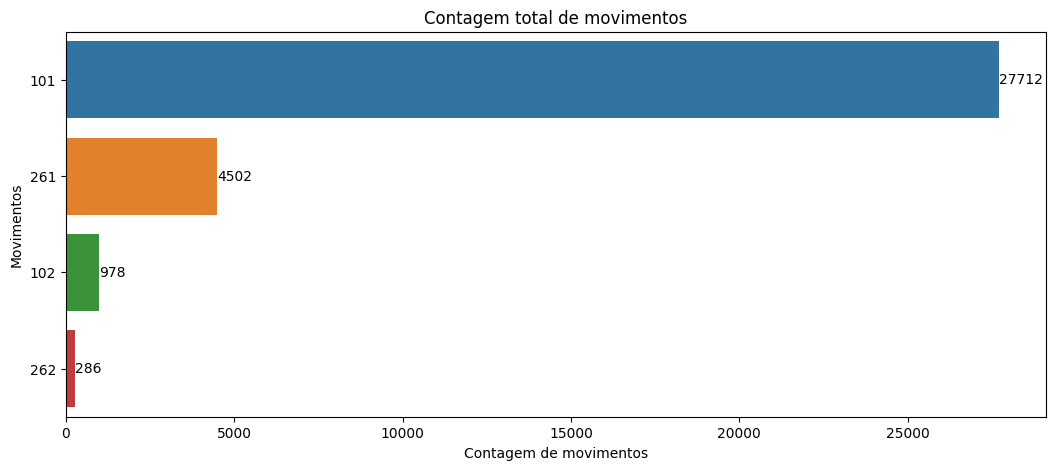

In [32]:
#Ajustando o tamanho do grafico
fig, ax = plt.subplots(figsize=(8, 5))

# Configurando a plotagem
ax = sns.barplot(data=dataset_movimentos, x='Contagem de movimentos', 
                 y=dataset_movimentos.index.values,ax = ax, orient = 'h')

# Plotando os valores das barras
for i in ax.containers:
    ax.bar_label(i,)

# Ajuste do titulo e nomes dos eixos
plt.title('Contagem total de movimentos')
plt.xlabel('Contagem de movimentos')
plt.ylabel('Movimentos')

# Ajustando a área de plotagem para que os valores não fiquem para fora
plt.subplots_adjust(right=1.35)
plt.show()

Antes de análisar o gráfico, é interessante relembrar o que cada um dos códigos significam:

**101**: Entrada de mercadorias (da ordem) para o estoque\
**102**: Estorno do movimento 101\
**261**: Saida de mercadorias (do estoque) para a ordem\
**262**: Estorno do movimento 261

Para exemplificar melhor, quando um material é produzido, utiliza-se uma bobina caster (ou um produto semi acabado), que é transformado em um produto acabado (ou em outro semi-acabado) + refugo. Como se trata de metais, o refugo pode ser considerado uma matéria prima novamente no processo. Os movimentos com final "2" são estornos, então podem ser considerados como movimentação contraria a que se originou.

Considerando as informações acima, podemos concluir que uma ordem de produção é composta de entradas (movimentos 261 e 102) e saidas (movimentos 262 e 101).

Considerando o que o gráfico mostra, podemos notar que os valores estão consistentes, e de acordo com o esperado. O maior numero de movimentos é o de código 101, que é a saida do material do ordem para o estoque, ou seja, produção de material acabado. Normalmente são produzidos diversos materiais a partir de uma bobina caster, então é correto que o movimento 101 seja o movimento mais frequente.

Os movimentos de estorno (102 e 262) são os que menos aparecem, o que tambem é o esperado, visto que o estorno normalmente é decorrente de algum erro.


### 5.2 Quantidade em kg em cada movimento

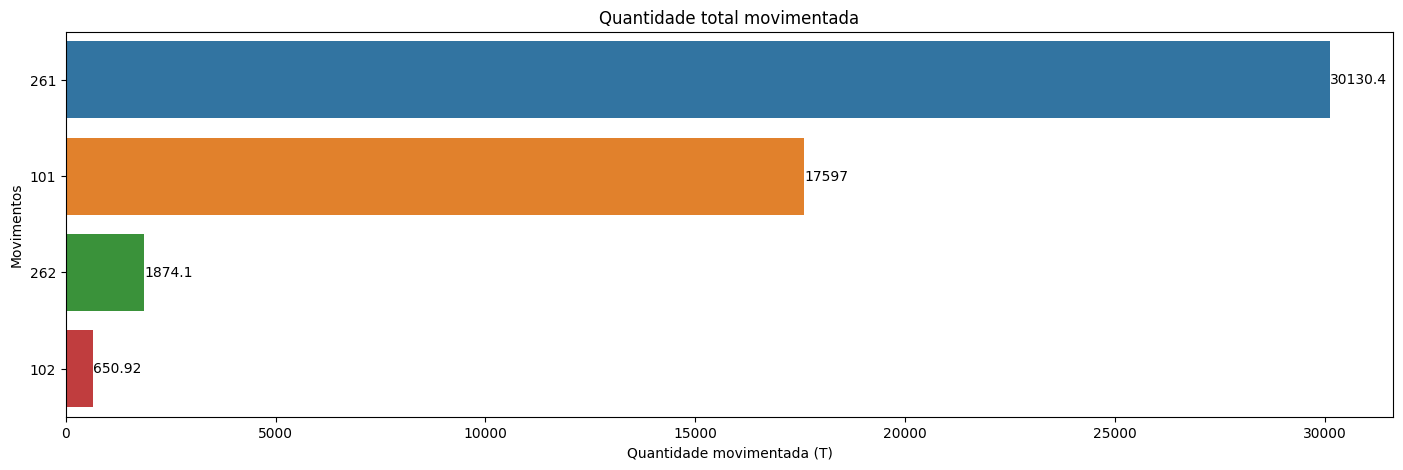

In [85]:
# Aplicando a função lambda para obter o valor absoluto, pois existem quantidades negativas
dataset_movimentos = dataset_movimentos.apply(lambda x : abs(x))

# Organiza do maior para o menor, em quantidade
dataset_movimentos = dataset_movimentos.sort_values(
    by='Quantidade', ascending=False)

# Ajustando o tamanho do grafico
fig, ax = plt.subplots(figsize=(9, 5))

# Configurando a plotagem
ax = sns.barplot(data=dataset_movimentos, 
                 x=round(dataset_movimentos['Quantidade'] / 1e3,2), 
                 y=dataset_movimentos.index.values,ax = ax, orient = 'h')

# Plotando os valores das barras
for i in ax.containers:
    ax.bar_label(i,)

# Ajuste do titulo e nomes dos eixos
plt.title('Quantidade total movimentada')
plt.xlabel('Quantidade movimentada (T)')
plt.ylabel('Movimentos')

# Ajustando a área de plotagem para que os valores não fiquem para fora
plt.subplots_adjust(right=1.6)
plt.show()

A partir da análise do gráfico acima, podemos tem uma noção da produção do empresa. Temos aproximadamente 28 mil toneladas de bobinas caster produzidas durante todo o periodo analizado e aproximadamente 17 mil toneladas de produto acabado produzido. Ao dividir um valor pelo outro, conseguimos determinar o rendimento metálico absoluto da fábrica, que fica em torno dos 0,6, ou 60%.

### 5.3 Quantidade em kg de produto acabado produzido mensamente

Os dataframes criados nesta sessão tambem serão usados na análise seguinte (Rendimento metálico mensal), por isso existem passos a mais que não serão usados neste análise (como por exemplo o filtro dos materiais semi acabados)

Para determinar a quantidade de produto acabado produzida mensamente, precisamos primeiramente filtrar os dados de maneira semelhante a que fizemos na outra análise:

In [34]:
'''
Primeiramente será feito uma query no dataset, utilizando duas condições:
- A Classificação precisa ser "Semi-acabado" e estar dentro da lista de bobinas 
caster definidas anteriormente, ou
- A classificação precisa ser "Acabado"
'''
produto_acabado_semi = dataset_finalizado.query(
    "Classificação == 'Semi-acabado' and "
    "`Material Alterado` in @lista_caster or "
    "Classificação == 'Acabado'")

O trecho de código a seguir é uma operação de filtro de dados. Basicamente, quatro novos DataFrames são criados a partir da seleção de linhas específicas do DataFrame produto_acabado_semi, com base em algumas condições.

A logica das condições é o seguinte:
- Nos datasets de produto semi-acabado, o tipo de movimento é 261 e 262, a classificação deve ser "semi-acabado", e o lote precisa ter uma string com tamanho igual a 7 (padrão dos lotes de materiais caster), alem de iniciar com o numero 2. 


- Nos datasets de produto acabado, o tipo de movimento é 101 ou 102, a classificação deve ser "acabado", e o lote precisa possuir uma string com tamanho igual a 10 (padrão dos lotes de materiais acabados), alem de iniciar com o numero 2.

O motivo destas restrições no lote, é para excluir da análise as linhas em que o lote não foi gerado da forma correta.

Exemplo do lote de um material caster: 22A0001
Exemplo do lote de um material acabado: 22A0001001

Todos os lotes devem iniciar com o numero dois, pois os primeiros dois digitos representam os anos.

In [35]:
produto_acabado_101 = produto_acabado_semi[
    (produto_acabado_semi['Tipo de movimento'] == '101') & 
    (produto_acabado_semi['Classificação'] == 'Acabado') &
    (produto_acabado_semi['Lote'].apply(lambda x : len(x)) == 10) &
    (produto_acabado_semi['Lote'].apply(lambda x : x.startswith('2')))
]

produto_acabado_102 = produto_acabado_semi[
    (produto_acabado_semi['Tipo de movimento'] == '102') & 
    (produto_acabado_semi['Classificação'] == 'Acabado') &
    (produto_acabado_semi['Lote'].apply(lambda x : len(x)) == 10) &
    (produto_acabado_semi['Lote'].apply(lambda x : x.startswith('2')))
]

produto_semi_acabado_261 = produto_acabado_semi[
    (produto_acabado_semi['Tipo de movimento'] == '261') & 
    (produto_acabado_semi['Classificação'] == 'Semi-acabado') & 
    (produto_acabado_semi['Lote'].apply(lambda x : len(x)) == 7) &
    (produto_acabado_semi['Lote'].apply(lambda x : x.startswith('2')))
]

produto_semi_acabado_262 = produto_acabado_semi[
    (produto_acabado_semi['Tipo de movimento'] == '262') & 
    (produto_acabado_semi['Classificação'] == 'Semi-acabado') & 
    (produto_acabado_semi['Lote'].apply(lambda x : len(x)) == 7) &
    (produto_acabado_semi['Lote'].apply(lambda x : x.startswith('2')))
]

In [36]:
# Verificação do tamanho dos novos datasets
print(produto_acabado_101.shape)
print(produto_acabado_102.shape)
print(produto_semi_acabado_261.shape)
print(produto_semi_acabado_262.shape)

(27685, 12)
(952, 12)
(4500, 12)
(286, 12)


No bloco de código a seguir, será feito um agrupamento de todos os dataframes construidos anteriormente. Esses valores serão agrupados pela quantidade, em cada mês.

In [37]:
# Agrupar por mês e somar a coluna "Quantidade, em cada mês"
produto_acabado_101_quantidade = produto_acabado_101.groupby(
    pd.Grouper(
        key='Data de lançamento', freq='M'))['Quantidade'].sum().reset_index()

produto_acabado_102_quantidade = produto_acabado_102.groupby(
    pd.Grouper(
        key='Data de lançamento', freq='M'))['Quantidade'].sum().reset_index()

produto_semi_acabado_261_quantidade = produto_semi_acabado_261.groupby(
    pd.Grouper(
        key='Data de lançamento', freq='M'))['Quantidade'].sum().reset_index()
        
produto_semi_acabado_262_quantidade = produto_semi_acabado_262.groupby(
    pd.Grouper(
        key='Data de lançamento', freq='M'))['Quantidade'].sum().reset_index()

# Verifica se foi feito
produto_acabado_101_quantidade.head(10)

,Data de lançamento,Quantidade
0,2022-01-31,784631.5
1,2022-02-28,1146938.0
2,2022-03-31,1406492.2
3,2022-04-30,956158.0
4,2022-05-31,1074413.0
5,2022-06-30,1059356.5
6,2022-07-31,1192690.0
7,2022-08-31,1178165.0
8,2022-09-30,1328377.5
9,2022-10-31,1333706.0


In [38]:
# Junta os dataframes de produto acabado em uma lista
produto_acabado_quantidade = [produto_acabado_101_quantidade, produto_acabado_102_quantidade]

# Concatena os dataframes
soma_quantidade = pd.concat(produto_acabado_quantidade).groupby(pd.Grouper(key='Data de lançamento', freq='M'))['Quantidade'].sum().reset_index()

# Exibe as primeiras linhas do novo dataframe
print(soma_quantidade)

   Data de lançamento  Quantidade
0          2022-01-31    758663.3
1          2022-02-28   1086917.0
2          2022-03-31   1328825.2
3          2022-04-30    927912.0
4          2022-05-31   1036793.0
5          2022-06-30   1033628.5
6          2022-07-31   1169894.0
7          2022-08-31   1157368.0
8          2022-09-30   1276768.5
9          2022-10-31   1290031.0
10         2022-11-30   1403582.0
11         2022-12-31   1018058.0
12         2023-01-31   1297342.0
13         2023-02-28   1549011.0
14         2023-03-31    610449.0


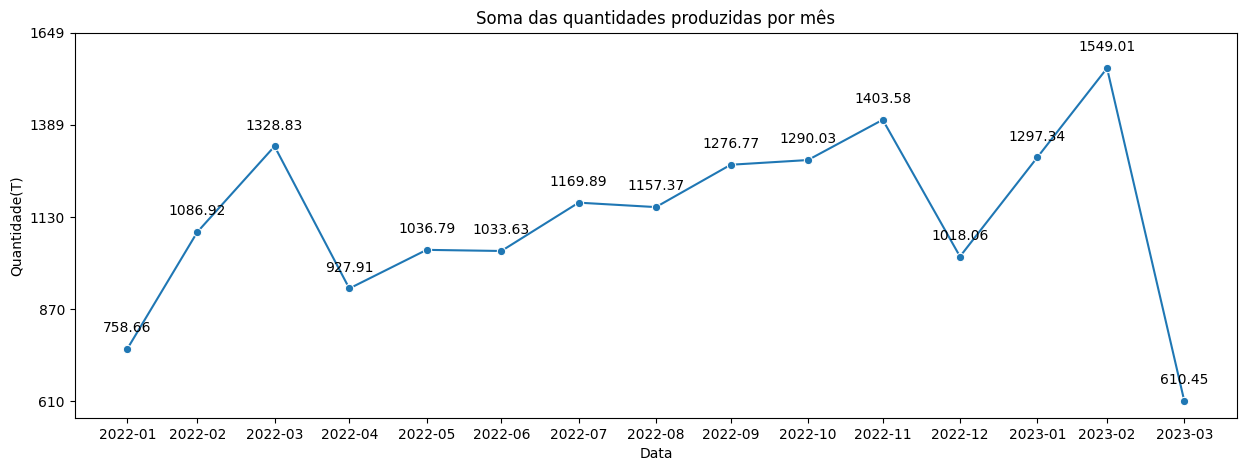

In [106]:
# Configura o tamanho da plotagem
fig, ax = plt.subplots(figsize=(15, 5))

# Configura os intervalos de y
yticks = np.linspace(int(soma_quantidade['Quantidade'].sort_values().to_list()[0] / 1e3), 
                     int(soma_quantidade['Quantidade'].sort_values().to_list()[-1] / 1e3 + 100), 
                     int(len(soma_quantidade['Quantidade'].to_list()) / 3))

# Plota o gráfico de linhas usando seaborn
ax = sns.lineplot(x='Data de lançamento', y=soma_quantidade['Quantidade'] / 1e3 , data=soma_quantidade, ax = ax,
    marker='o', dashes=False)

# Plotando os valores das barras
for x, y in zip(soma_quantidade['Data de lançamento'], soma_quantidade['Quantidade'] / 1e3):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', va='bottom')

# Configura o título do gráfico e dos eixos
plt.title('Soma das quantidades produzidas por mês')
plt.xlabel('Data')
plt.ylabel('Quantidade(T)')

# Seta os ticks de y e x
ax.set(xticks = soma_quantidade['Data de lançamento'].values, yticks=yticks)
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m"))

# Ajustando a área de plotagem para que os valores não fiquem para fora
plt.show()

Ao analisar o gráfico acima, podemos chegar em algumas conclusões interessantes:

- Os valores referentes a janeiro de 2022 (primeiro mês do registro) provavlemente não estão corretos, pois estão muito abaixo do padrão dos outros meses. Isso provavelmente ocorreu pois foi o mes onde houve a mudança do sistema antigo para o novo.

- Houve uma queda grande de produção no mês de abril de 2022. Os movitos podem ser muitos, mas Infelizmente não é possivel determinar o motivo apenas com estes dados.

- Podemos notar que ouve um crescimento constante na produção ao longo dos meses, desde abril de 2022 até novembro de 2022.

- O mês de março de 2023 tambem não possui valores realistas, pois os dados foram retirados no inicio deste mês.

- É possivel que exista algum comportamento ciclico da produção, mas como existem poucos dados sendo analisados,  não é possivel afirmar isso ainda.

### 5.4 Rendimento metalico mensal

Boa tarde das transformações usadas nesta análise já foram feitas na sessão anterior, e podem ser aproveitadas

In [40]:
# Gerando listas de entrada e saida de materiais
quantidade_entrada = [produto_semi_acabado_261_quantidade, produto_semi_acabado_262_quantidade]
quantidade_saida = [produto_acabado_101_quantidade, produto_acabado_102_quantidade]

# Concatenando os datasets de entrada (e aplicando o absoluto, pois existem valores negativos)
entrada = pd.concat(quantidade_entrada).groupby(pd.Grouper(key='Data de lançamento', freq='M'))['Quantidade'].sum().reset_index()
entrada['Quantidade'] = entrada['Quantidade'].apply(lambda x: abs(x))

# Concatenando os datasets de saida
saida = pd.concat(quantidade_saida).groupby(pd.Grouper(key='Data de lançamento', freq='M'))['Quantidade'].sum().reset_index()

# Determinando o rendimento metálico
rm = [a / b for a, b in zip(saida['Quantidade'], entrada['Quantidade'])]

rm

[0.4681485608995897,
 0.6882854620730183,
 0.6250150865282359,
 0.550245825473698,
 0.603775559618787,
 0.5870706102426184,
 0.5664425620083965,
 0.5276961196798649,
 0.5568465951837338,
 0.6589648030224283,
 0.6041061322551448,
 0.739718036421205,
 0.5757596072829719,
 0.6920167566043797,
 0.5768928722970948]

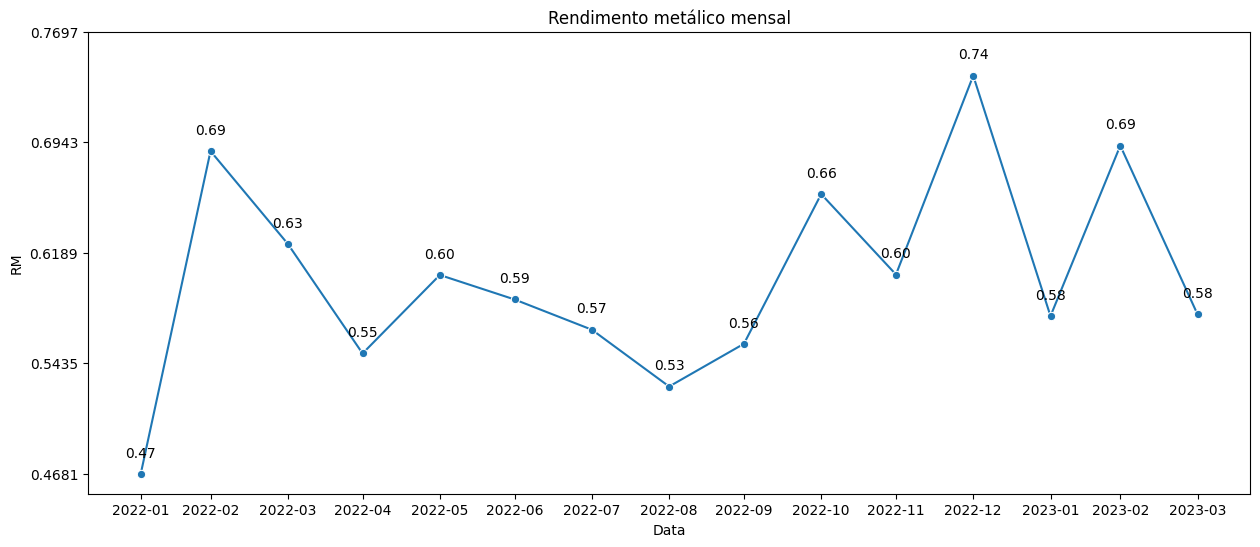

In [114]:
# Configura o tamanho da plotagem
fig, ax = plt.subplots(figsize=(15, 6))

# Configura os intervalos de y
yticks = np.linspace(min(rm), max(rm) + 0.03, int(len(rm) / 3))

# Plota o gráfico de linhas usando seaborn
sns.lineplot(x='Data de lançamento', y = rm , data=soma_quantidade, ax = ax, marker='o')

# Plotando os valores das barras
for x, y in zip(soma_quantidade['Data de lançamento'], rm):
    plt.annotate(f'{y:.2f}', (x, y), textcoords='offset points', xytext=(0, 10), ha='center', va='bottom')

# Configura o título do gráfico e dos eixos
plt.title('Rendimento metálico mensal')
plt.xlabel('Data')
plt.ylabel('RM')

# Seta os ticks de y e x
ax.set(xticks = soma_quantidade['Data de lançamento'].values, yticks = yticks)
ax.xaxis.set_major_formatter(dates.DateFormatter("%Y-%m"))

# Exibe o gráfico
plt.show()

O gráfico acima mostra o rendimento metálico mensal, que é definido pela divisão do que feito de produto acabado pelo que é feito de bobinas caster (matéria prima). Podemos notar que existe uma tendencia bem sutil de aumento desta variavel no decorrer dos meses.

Do mesmo modo da análise dos produtos acabados, podemos ignorar os meses de janeiro de 2022 e março de 2023, pois são dados incorretos.

É interessante notar que nos meses onde houve um aumento visivel da produção (comentado no gráfico passado) houve uma redução do rendimento metalico mensal.

### 5.5 Os dez itens mais produzidos

In [42]:
produto_acabado = dataset_finalizado[dataset_finalizado['Classificação'] == 'Acabado']

In [43]:
soma_produtos = produto_acabado.groupby('Material Alterado')['Quantidade'].sum().reset_index().sort_values(by = 'Quantidade', ascending = False)
soma_produtos = soma_produtos.head(10)

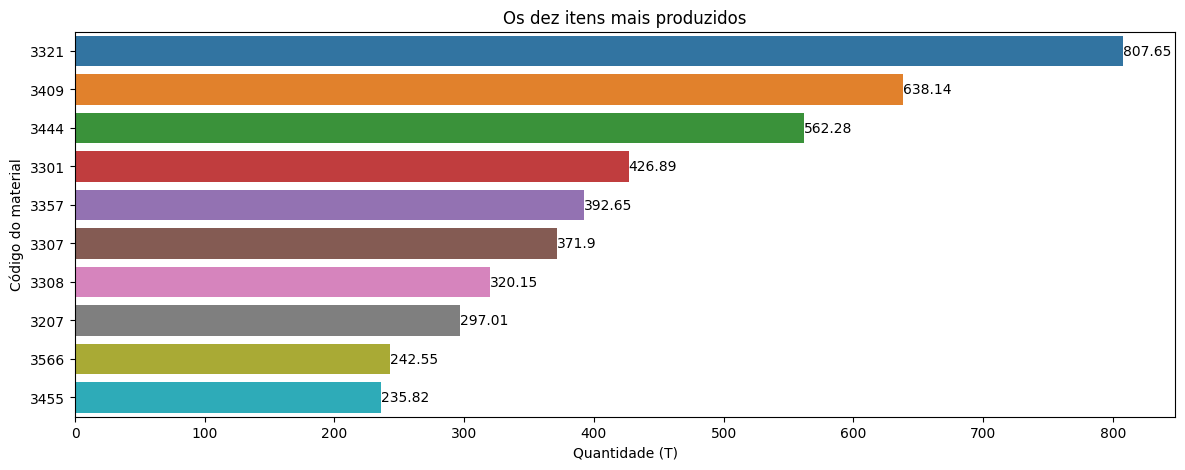

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))

ax = sns.barplot(data=soma_produtos, x=round(soma_produtos['Quantidade'] / 1e3, 2), y="Material Alterado",ax = ax, orient = 'h')

for i in ax.containers:
    ax.bar_label(i,)

# Configura o título do gráfico e dos eixos
plt.title('Os dez itens mais produzidos')
plt.xlabel('Quantidade (T)')
plt.ylabel('Código do material')

plt.subplots_adjust(right=1.5)
plt.show()

Este gráfico tem pouco uso quando não se tem conhecimento dos valores reais dos códigos dos materiais. No entanto, pode ser útil para desenvolver um modelo de aprendizado de máquina capaz de prever a quantidade mensal de produção de cada material.

## 6. Separação em conjunto de treino e conjunto de teste

Nesta etapa, será criado mais uma instancia dos dados, dessa vez com o objetivo de preparar o dataset para o uso em um futuro algoritmo de machine learning.

In [68]:
# Instanciando o dataset com as colunas que serão usadas
dataset_ML = dataset_finalizado[['Tipo de movimento', 'Data de lançamento', 
                                 'Material Alterado', 'Classificação',  
                                 'UM registro','Quantidade']]

# Filtrando apenas as unidades em massa (kg)
dataset_ML = dataset_ML[dataset_ML['UM registro'] == 'KG']

# Filtrando os materiais acabaos e semi acabados
dataset_ML = dataset_ML[(dataset_ML['Classificação'] == 'Acabado') | (
    dataset_ML['Classificação'] == 'Semi-acabado')]

# Dividindo a coluna de data em mes e ano, para facilitar as analises
dataset_ML['Ano'] = dataset_ML['Data de lançamento'].dt.year
dataset_ML['Mês'] = dataset_ML['Data de lançamento'].dt.month

# Aplicando o absoluto nos valores de quantidade
dataset_ML['Quantidade'] = dataset_ML['Quantidade'].apply(lambda x : abs(x))

# Dropando as colunas que não serão mais uteis
dataset_ML.drop(columns = ['Data de lançamento', 'UM registro'], inplace = True)

dataset_ML.head()

,Tipo de movimento,Material Alterado,Classificação,Quantidade,Ano,Mês
2,101,3207,Acabado,1212.0,2023,3
3,101,3207,Acabado,1423.0,2023,3
4,101,3207,Acabado,1422.0,2023,3
6,101,3207,Acabado,1150.0,2023,3
7,101,3207,Acabado,1211.0,2023,3


In [69]:
# Transformando as colunas para valores numericos, para ser usado na normalização
dataset_ML['Tipo de movimento'] = pd.to_numeric(dataset_ML['Tipo de movimento'])
dataset_ML['Material Alterado'] = pd.to_numeric(dataset_ML['Material Alterado'])
dataset_ML['Quantidade'] = pd.to_numeric(dataset_ML['Quantidade'])

In [70]:
# Transformação dos atributos categoricos em binarios

encoder = OneHotEncoder(drop = 'first', sparse = False)

dummy = encoder.fit_transform(dataset_ML['Classificação'].values.reshape(-1, 1))

print(dummy)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


In [71]:
# juntar os conjuntos de dados
dataset_ML['Classificação'] = dummy

dataset_ML['Classificação'] = dataset_ML['Classificação'].apply(lambda x : int(x))

In [73]:
dataset_ML = dataset_ML[['Tipo de movimento', 'Material Alterado', 'Classificação', 'Ano','Mês','Quantidade']]
dataset_ML.head()

,Tipo de movimento,Material Alterado,Classificação,Ano,Mês,Quantidade
2,101,3207,0,2023,3,1212.0
3,101,3207,0,2023,3,1423.0
4,101,3207,0,2023,3,1422.0
6,101,3207,0,2023,3,1150.0
7,101,3207,0,2023,3,1211.0


In [74]:
dataset_ML.shape

(108026, 6)

In [75]:
test_size = 0.20
seed = 7

# Separação em conjuntos de treino e teste (dataset original)
array = dataset_ML.values
X = array[:,0:5]
y = array[:,5]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed)

In [76]:
X_train.shape

(86420, 5)

In [77]:
X_test.shape

(21606, 5)

In [78]:
y_train.shape

(86420,)

In [79]:
y_test.shape

(21606,)

In [80]:
# Aplicação da padronização
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)